## Laboratorio 3
- La práctica consiste en diseñar una red neuronal que permita clasificar imagenes que contienen gatos. El objetivo es encontrar un buen rendimiento del sistema.
- El sistema se debe evaluar con los parametros obenidos por la matriz de confusión tales como accuracy, tasa de error,  sencibildad, especificidad, precisión, VPN


In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split as tts
import cv2 as cv

import os
from sklearn.utils import shuffle

import pickle

from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [232]:
def charge_dataset(ruta):
    File = open(ruta, 'rb')
    data_x_tmp = pickle.load(File)
    data_y = pickle.load(File)
    File.close()
    del(File)
    return data_x_tmp, data_y

def show_img(data_x_tmp, data_y, index_img=255):   
    plt.imshow(data_x_tmp[index_img])
    if data_y[index_img, 0]:
        print (">>> La imgen No. {} del conjunto Esta etiquetado como gato.".format(index_img))
    else:
        print (">>> La imgen No. {} del conjunto NO esta etiquetado como gato".format(index_img))

def get_new_colmns(data_x_tmp):
    new_colmns = 1
    for i in range(3):
        new_colmns *= data_x_tmp.shape[i+1]
    return new_colmns

def  x_reshape_and_normalize(data_x_tmp):
    rows = data_x_tmp.shape[0]
    new_colmns = get_new_colmns(data_x_tmp)
    data_x = data_x_tmp.reshape((rows,new_colmns))
    colmns = data_x.shape[1]
    print("Nuevas dimensiónes de X {}".format(data_x.shape))
    print('\n>>> Datos de X sin normalizar: \r\n {}\n'.format(data_x))
    # Normalizamos los datos.
    data_x = data_x/255 
    print('>>> Datos de X normalizados: \r\n {}\n'.format(data_x))
    return data_x, rows, colmns

In [233]:
# Obtencion y normalizacion de datos
ruta = ('dataset/data.pckl')
index_img = 20  ### Se puede cambiar el indice (0-258)
def dataset_init(ruta, index_img):
    data_x_tmp, data_y = charge_dataset(ruta)
    print("Dimensión de X {}".format(data_x_tmp.shape))
    print("Dimensión de Y {}".format(data_y.shape))
    show_img(data_x_tmp, data_y, index_img)
    data_x, rows, colmns = x_reshape_and_normalize(data_x_tmp)
    return data_x, data_y, rows, colmns

- dat_X es un tensor de 4 dimenciones, el cual tiene información de 259 imagenes de 64 pixeles por 64 pixeles y tres capas (RGB)
- dat_Y es un vector columna de 259 posiciones que contiene las etiquetas (labels) de las imagenes contenidas en dat_X, (1: Es gato, 0: No es gato)

## Recomendaciones
- Ajustar los datos a la forma como se han venido trabajando en clase (Matriz de 259 x 12288) ayudarse de la función "reshape"" de numpy
- Normalizar los datos entre 0-1 (Las imagenes estan entre 0-255), basicamente es dividir los datos de X en 255
- Debido a que el conjunto de entrenamiento es reducido, se recomienda hacer validación cruzada al momento de entrenar y validar.
- Se puede mejorar el sistema incluyendo al conjunto de datos nuevas imagenes, tener en cuenta que las imagenes deben ser de tamaño (64*64*3), se pueden ayudar de la función "imresize" de paquetes como scipy, cv2
- Tener por lo menos dos capas ocultas.

Dimensión de X (13027, 64, 64, 3)
Dimensión de Y (13027, 1)
>>> La imgen No. 20 del conjunto NO esta etiquetado como gato
Nuevas dimensiónes de X (13027, 12288)

>>> Datos de X sin normalizar: 
 [[ 17  31  56 ...   0   0   0]
 [196 192 190 ...  82  80  81]
 [ 82  71  68 ... 138 141 142]
 ...
 [ 46  46  48 ... 247 243 244]
 [ 96  96  96 ...  58  58  58]
 [128 153 150 ... 156 140 114]]

>>> Datos de X normalizados: 
 [[0.06666667 0.12156863 0.21960784 ... 0.         0.         0.        ]
 [0.76862745 0.75294118 0.74509804 ... 0.32156863 0.31372549 0.31764706]
 [0.32156863 0.27843137 0.26666667 ... 0.54117647 0.55294118 0.55686275]
 ...
 [0.18039216 0.18039216 0.18823529 ... 0.96862745 0.95294118 0.95686275]
 [0.37647059 0.37647059 0.37647059 ... 0.22745098 0.22745098 0.22745098]
 [0.50196078 0.6        0.58823529 ... 0.61176471 0.54901961 0.44705882]]



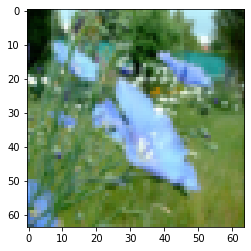

In [234]:
# Obtengo mis datos
data_x, data_y_tmp, rows, colmns = dataset_init(ruta, index_img)

In [235]:
number_img = 10
oneHot = OneHotEncoder()
oneHot.fit(data_y_tmp)
data_y = oneHot.transform(data_y_tmp).toarray()
print(data_y[number_img,:])

C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[1. 0.]


In [236]:
# Realizamos el split de los datos
X_train, X_test, Y_train, Y_test = tts(data_x, data_y, test_size=0.1, random_state=None) 
print('Train:{}, Test {}'.format(X_train.shape,X_test.shape))

Train:(11724, 12288), Test (1303, 12288)


In [237]:
# Cargamos los Hiparparametros
samples = np.shape(X_train)[0]
#learning_rate = 0.0001
learning_rate = 0.00009
num_epochs = 1000
display_step = 10
batch_size = int(samples*0.1)
number_batch = int(samples//batch_size) 
hidden_layer_size = 200        # Número de neuronas en capa oculta
n_char = np.shape(X_train)[1]    # Número de cararcteristicas
n_class = np.shape(Y_train)[1]   # Número de clases
print(number_batch)

10


In [238]:
# Iniciamos las variables y los Place Holders
tf.reset_default_graph()
X_ph = tf.placeholder(tf.float32, [batch_size, n_char])
Y_ph = tf.placeholder(tf.float32, [batch_size, n_class])

In [239]:
# definimos la estructura (HIpotesis) del modelo
weight_1 = tf.get_variable("weight_1",[n_char, hidden_layer_size])
bias_1 = tf.get_variable("bias_1",[hidden_layer_size])
logits_2 = tf.matmul(X_ph, weight_1) + bias_1
activation_2 = tf.nn.relu(logits_2)

weight_2 = tf.get_variable("weight_2",[hidden_layer_size, hidden_layer_size])
bias_2 = tf.get_variable("bias_2",[hidden_layer_size])
logits_3 = tf.matmul(activation_2, weight_2) + bias_2
activation_3 = tf.nn.tanh(logits_3)

weight_3 = tf.get_variable("weight_3",[hidden_layer_size, hidden_layer_size])
bias_3 = tf.get_variable("bias_3",[hidden_layer_size])
logits_4 = tf.matmul(activation_3, weight_3) + bias_3
activation_4 = tf.nn.relu(logits_4)

weight_4 = tf.get_variable("weight_4",[hidden_layer_size, hidden_layer_size])
bias_4 = tf.get_variable("bias_4",[hidden_layer_size])
logits_5 = tf.matmul(activation_4, weight_4) + bias_4
activation_5 = tf.nn.tanh(logits_5)

weight_f = tf.get_variable("weight_f",[hidden_layer_size, n_class])
bias_f = tf.get_variable("bias_f",[n_class])
logits = tf.add(tf.matmul(activation_5, weight_f),bias_f)
y_ = tf.nn.relu(logits)

prediccion = tf.equal(tf.argmax(y_, 1), tf.argmax(Y_ph, 1))

In [240]:
print('{}, {}'.format(weight_1.shape, X_ph.shape))

(12288, 200), (1172, 12288)


In [241]:
# Calculamos la funcion de costo.
J = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y_ph, logits=logits)
mean_J = tf.reduce_mean(J)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_J)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(mean_J)

accuracy = tf.reduce_mean(tf.cast(prediccion, tf.float32))
saver = tf.train.Saver()

In [242]:
increm_control = 0
break_out = 5
train_cost = []
validation_cost = []
prev_validation_accuracy = 0
with tf.name_scope("starting_tensorflow_session"):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        cont = 0
        for epoch in range(num_epochs):
            X_tmp, Y_tmp = shuffle(X_train, Y_train)
            for batch in range(number_batch-1):
                b_x = X_tmp[batch*batch_size:(batch+1)*batch_size]
                b_y = Y_tmp[batch*batch_size:(batch+1)*batch_size]
                _, t_cost = sess.run([optimizer, mean_J], feed_dict={X_ph: b_x, Y_ph: b_y})
                train_cost.append(t_cost)                
            batch = batch + 1
            b_x = X_tmp[batch*batch_size:(batch+1)*batch_size]
            b_y = Y_tmp[batch*batch_size:(batch+1)*batch_size]
            v_cost, v_accuracy = sess.run([mean_J, accuracy], feed_dict={X_ph: b_x, Y_ph: b_y})
            validation_cost.append(v_cost)         
            if (epoch+1) % display_step == 0:
                print("Epoch: {}".format(epoch + 1), "train_cost={:0.4f}".format(t_cost), 
                      "validation_cost={:0.4f}".format(v_cost), "validation_accuracy={:0.2f}%".format(v_accuracy*100))
            if t_cost < 0.1:
                increm_control += 1
            if increm_control == 5:
                break_out = 3
    
            if v_accuracy <= prev_validation_accuracy:
                cont = cont+1;
            else:
                cont = 0
            if cont > break_out:
                break
            prev_validation_accuracy = v_accuracy
        print('Entrenamiento Finalizado')
        saver.save(sess, os.getcwd()+"/modelo2.ckpt")        

Epoch: 10 train_cost=0.4349 validation_cost=0.4612 validation_accuracy=80.29%
Epoch: 20 train_cost=0.3653 validation_cost=0.3996 validation_accuracy=82.85%
Epoch: 30 train_cost=0.3291 validation_cost=0.2960 validation_accuracy=87.46%
Epoch: 40 train_cost=0.2417 validation_cost=0.2343 validation_accuracy=90.70%
Epoch: 50 train_cost=0.1858 validation_cost=0.1589 validation_accuracy=94.28%
Epoch: 60 train_cost=0.1506 validation_cost=0.2548 validation_accuracy=89.68%
Epoch: 70 train_cost=0.1076 validation_cost=0.0888 validation_accuracy=97.87%
Epoch: 80 train_cost=0.1709 validation_cost=0.0966 validation_accuracy=97.10%
Epoch: 90 train_cost=0.0594 validation_cost=0.0600 validation_accuracy=98.55%
Epoch: 100 train_cost=0.0428 validation_cost=0.0428 validation_accuracy=98.89%
Entrenamiento Finalizado




# Test

#### Apartir de aqui corre el test
     - Falta corregir errores en la redaccion.
     - Modularizar la hipotesis.

In [243]:
tf.reset_default_graph()
X_ph = tf.placeholder(tf.float32, [None, n_char])
Y_ph = tf.placeholder(tf.float32, [None, n_class])

weight_1 = tf.get_variable("weight_1",[n_char, hidden_layer_size])
bias_1 = tf.get_variable("bias_1",[hidden_layer_size])
logits_2 = tf.matmul(X_ph, weight_1) + bias_1
activation_2 = tf.nn.relu(logits_2)

weight_2 = tf.get_variable("weight_2",[hidden_layer_size, hidden_layer_size])
bias_2 = tf.get_variable("bias_2",[hidden_layer_size])
logits_3 = tf.matmul(activation_2, weight_2) + bias_2
activation_3 = tf.nn.tanh(logits_3)

weight_3 = tf.get_variable("weight_3",[hidden_layer_size, hidden_layer_size])
bias_3 = tf.get_variable("bias_3",[hidden_layer_size])
logits_4 = tf.matmul(activation_3, weight_3) + bias_3
activation_4 = tf.nn.relu(logits_4)

weight_4 = tf.get_variable("weight_4",[hidden_layer_size, hidden_layer_size])
bias_4 = tf.get_variable("bias_4",[hidden_layer_size])
logits_5 = tf.matmul(activation_4, weight_4) + bias_4
activation_5 = tf.nn.tanh(logits_5)

weight_f = tf.get_variable("weight_f",[hidden_layer_size, n_class])
bias_f = tf.get_variable("bias_f",[n_class])
logits = tf.add(tf.matmul(activation_5, weight_f),bias_f)
y_ = tf.nn.relu(logits)


predice = tf.argmax(y_, 1)
prediccion = tf.equal(tf.argmax(y_, 1), tf.argmax(Y_ph, 1))
accuracy = tf.reduce_mean(tf.cast(prediccion, tf.float32))
conf_matrix = tf.confusion_matrix(tf.argmax(y_, 1), tf.argmax(Y_ph, 1))
print(conf_matrix.shape)
#saver = tf.train.Saver()
#with tf.Session() as sess:
 #   saver.restore(sess, os.getcwd()+"/modelo2.ckpt")
 #   test_accuracy = sess.run([accuracy], feed_dict={X_ph: X_test, Y_ph: Y_test})
 #   test_accuracy_percent = test_accuracy[0] * 100.
 #   print('Test accuracy: '+'{0:.2f}'.format(test_accuracy_percent)+'%')
 #   predice = sess.run([predice], feed_dict={X_ph: X_test, Y_ph: Y_test}) 
 #   conf_mat = sess.run([conf_matrix ], feed_dict={X_ph: X_test, Y_ph: Y_test})
#    print(conf_mat[0])

(?, ?)


In [244]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, os.getcwd()+"/modelo2.ckpt")
    test_accuracy = sess.run([accuracy], feed_dict={X_ph: X_test, Y_ph: Y_test})
    test_accuracy_percent = test_accuracy[0] * 100.
    print('Test accuracy: '+'{0:.2f}'.format(test_accuracy_percent)+'%')
    predice = sess.run([predice], feed_dict={X_ph: X_test, Y_ph: Y_test}) 
    conf_mat = sess.run([conf_matrix ], feed_dict={X_ph: X_test, Y_ph: Y_test})
    print(conf_mat[0])

Test accuracy: 90.64%
[[423  48]
 [ 74 758]]


In [245]:
Vp = conf_mat[0][0][0] 
Fn = conf_mat[0][0][1]
Fp = conf_mat[0][1][0]
Vn = conf_mat[0][1][1]
print('{}, {}'.format(weight_1.shape, X_ph.shape))

(12288, 200), (?, 12288)


Esta etiquetado como un: gato
Lo predice como un como un: gato


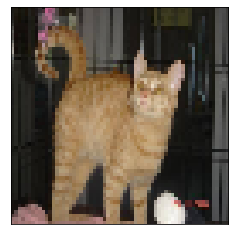

In [267]:
index = 53
img = X_test[index][0:colmns];
img_reshape = img.reshape([64,64,3])
#m2 = im2.T;
plt.imshow(img_reshape)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
if(np.argmax(Y_test[index]) == 1):
    etiqueta = 'gato'
else: 
    etiqueta = 'no gato'

if(predice[0][index] == 1):
    res = 'gato'
else: 
    res = 'no gato'
    
print('Esta etiquetado como un: {}'.format(etiqueta))
print('Lo predice como un como un: {}'.format(res))

Text(0.5, 257.44, 'No_gatos    -    gatos')

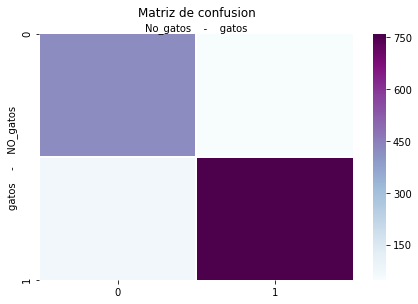

In [247]:
### class_name = [0, 1]
class_labels = ['no gatos','gatos']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

sns.heatmap(pd.DataFrame(conf_mat[0]), cmap="BuPu", annot=False,
            fmt='d', linewidths=1 ,annot_kws={"size": 20})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Matriz de confusion')
plt.ylabel('gatos    -    NO_gatos')
plt.xlabel('No_gatos    -    gatos')

In [248]:
positive = Vp + Fn
negative = Fp + Vn
print("Positivos: {}, Negativos: {}.".format(positive, negative))

Positivos: 471, Negativos: 832.


In [249]:
pred_positive = Vp + Fp
pred_negative = Vn + Fn
print("Predichos Positivos: {}, Predichos Negativos: {}.".format(pred_positive, pred_negative))

Predichos Positivos: 497, Predichos Negativos: 806.


In [250]:
mtx_total = positive + negative
mtx_accuracy = ((Vp + Vn)/mtx_total) * 100
mtx_error_rate = ((Fp + Fn)/mtx_total) * 100
mtx_sensibility = (Vp/pred_positive) * 100
mtx_specificity = (Vn/pred_negative) * 100
print("Accuracy: {:.4f}%, Error Rate: {:.4f}%, Sensibility: {:.4f}%, Specificity: {:.4f}%."
      .format(mtx_accuracy, mtx_error_rate, mtx_sensibility, mtx_specificity))

Accuracy: 90.6370%, Error Rate: 9.3630%, Sensibility: 85.1107%, Specificity: 94.0447%.


In [251]:
mtx_precision = (Vp/positive) * 100 
mtx_vpn = (Vn/negative) * 100
print("Precision: {:.2f}%, Prediction: {:.2f}%".format(mtx_precision, mtx_vpn))

Precision: 89.81%, Prediction: 91.11%
